# Module 3

## Final Project Submission

Please fill out:
* Student name: Joshua Brancazio
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: Rafael
* Blog post URL: https://jbrancazio.github.io/classification_model


In [1]:
#import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

np.random.seed(6218)

#set graphing preferences
import matplotlib.style as style
style.use('seaborn-poster')
style.use('ggplot')
%matplotlib inline

#import model libraries
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import xgboost as xgb
from sklearn.pipeline import Pipeline

#import other libraries
from sklearn.metrics import roc_curve, auc, accuracy_score,f1_score,confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

# Obtain

The data I will be using for this project is a dataset that is maintained by [UCI](//archive.ics.uci.edu/ml/datasets/bank+marketing#). 

**For this project, my goal will be to create a model using the data to predict whether or not a customer will subscribe to Term Deposit.**

In [2]:
#load DataFrame
raw_df=pd.read_csv('bank_customer_survey.csv')
raw_df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0


In [3]:
#check feat datatypes
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null int64
dtypes: int64(8), object(9)
memory usage: 5.9+ MB


In [4]:
#describe numerical data
raw_df.describe()

,age,balance,day,duration,campaign,pdays,previous,y
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323,0.116985
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441,0.321406
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,1.000000


In [5]:
#check for null values
raw_df.isna().any().any()

False

Detailed notes about features in the datatset:

* **age**: [numerical]
* **job**: Type of Job [categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown"]
* **marital**: Marital status [categorical: "divorced","married","single","unknown"]
* **education**: Level of education [categorical: "primary","secondary","tertiary","unknown"]
* **default**: Has credit in default? [binary: "no","yes"]
* **balance**: Average yearly balance [numerical: in euros]
* **housing**: has housing loan? [binary: "no","yes"]
* **loan**: has personal loan? [binary: "no","yes"]
* **contact**: contact communication type [categorical: "cellular","telephone"]
* **day**: last contact day of the week [categorical: "mon","tue","wed","thu","fri"]
* **month**: last contact month of year [categorical: "jan", "feb", ..., "nov", "dec"]
* **duration**: last contact duration [numerical: in seconds]
* **campaign**: number of contacts performed during this campaign and for this client [numerical]
* **pdays**: number of days that passed by after the client was last contacted from a previous campaign [numerical]
* **previous**: number of contacts performed before this campaign and for this client [numerical]
* **poutcome**: outcome of the previous marketing campaign [categorical: "failure","nonexistent","success"]
* **y**: Whether or not the customer has term deposit [binary: "no","yes"]

# Scrub

In [6]:
#create feature dataframe without target
feat = raw_df.drop(['duration','y'],axis=1)
feat.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown


In [7]:
# convert default, housing and loan to binary coding
binary_feats=['default','housing','loan']
for binary_feat in binary_feats:
    feat[binary_feat]=feat[binary_feat].map({'no':0,'yes':1})
feat.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,1,-1,0,unknown
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,1,-1,0,unknown
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,1,-1,0,unknown


In [8]:
#one-hot encoding for categorical data
one_hot_feat=pd.get_dummies(feat)
one_hot_feat.head(3)

,age,default,balance,housing,loan,day,campaign,pdays,previous,job_admin,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,0,2143,1,0,5,1,-1,0,0,...,0,0,1,0,0,0,0,0,0,1
1,44,0,29,1,0,5,1,-1,0,0,...,0,0,1,0,0,0,0,0,0,1
2,33,0,2,1,1,5,1,-1,0,0,...,0,0,1,0,0,0,0,0,0,1


In [9]:
#scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(one_hot_feat)

scaled_feat = pd.DataFrame(scaled_data, columns=one_hot_feat.columns)
scaled_feat.head(3)

,age,default,balance,housing,loan,day,campaign,pdays,previous,job_admin,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,1.606965,-0.13549,0.256419,0.893915,-0.436803,-1.298476,-0.569351,-0.411453,-0.25194,-0.359369,...,-0.366006,-0.103262,1.511374,-0.310263,-0.128819,-0.113898,-0.348687,-0.205972,-0.185948,0.472519
1,0.288529,-0.13549,-0.437895,0.893915,-0.436803,-1.298476,-0.569351,-0.411453,-0.25194,-0.359369,...,-0.366006,-0.103262,1.511374,-0.310263,-0.128819,-0.113898,-0.348687,-0.205972,-0.185948,0.472519
2,-0.747384,-0.13549,-0.446762,0.893915,2.289359,-1.298476,-0.569351,-0.411453,-0.25194,-0.359369,...,-0.366006,-0.103262,1.511374,-0.310263,-0.128819,-0.113898,-0.348687,-0.205972,-0.185948,0.472519


In [10]:
raw_df['y'].value_counts()

0    39922
1     5289
Name: y, dtype: int64

# Explore

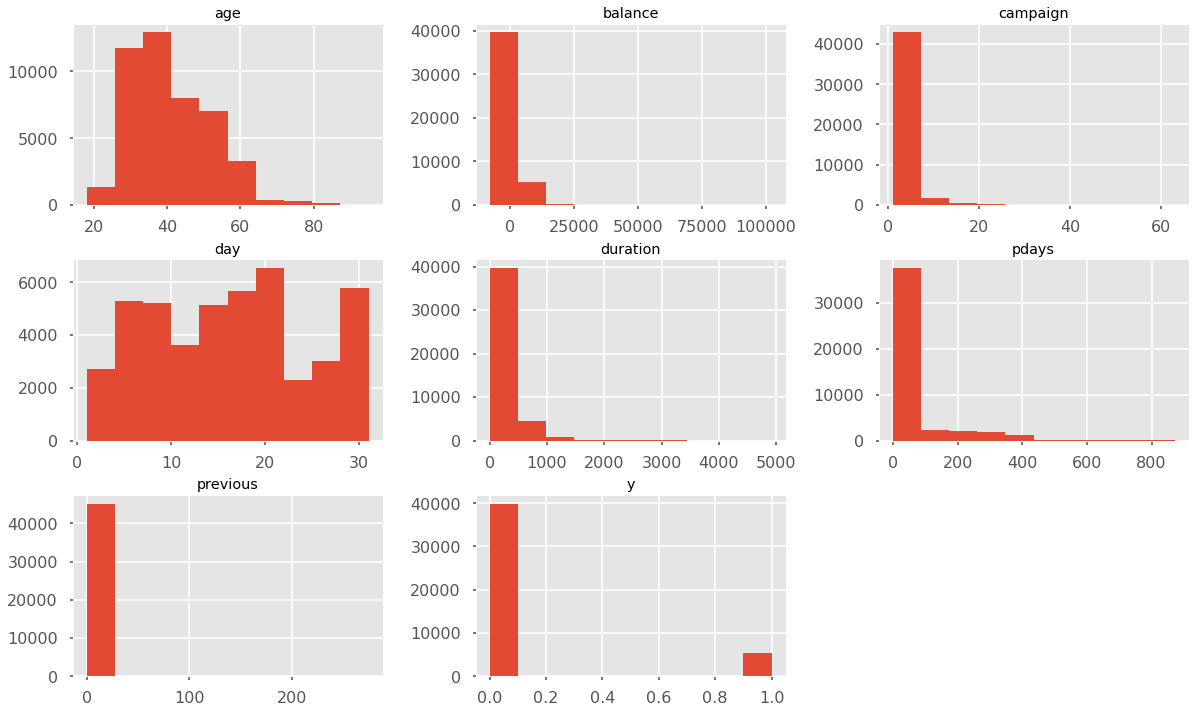

In [11]:
raw_df.hist(figsize=(20,12));

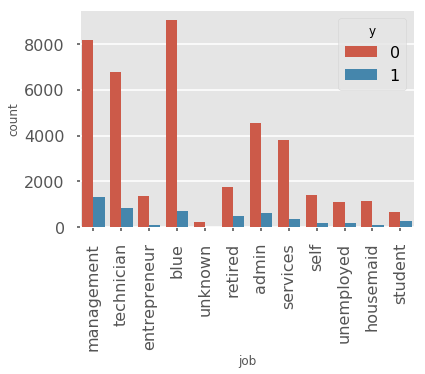

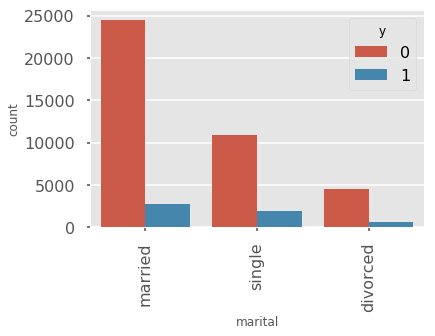

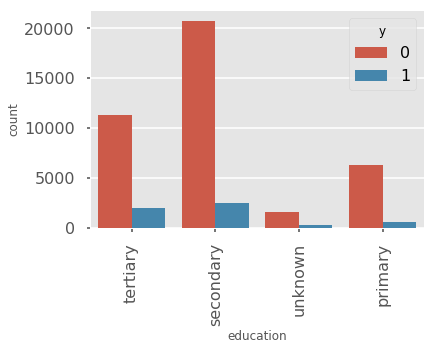

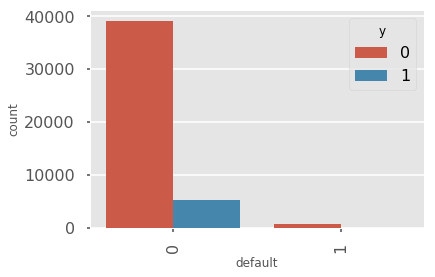

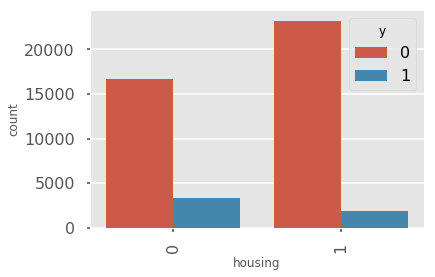

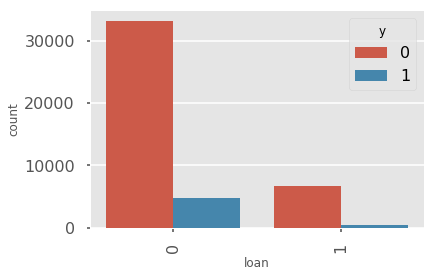

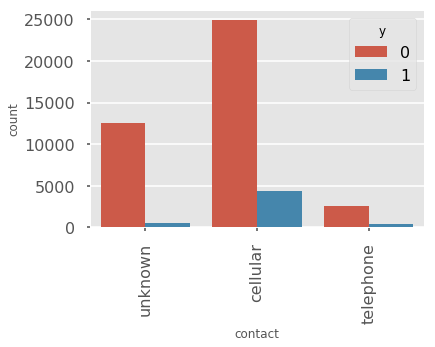

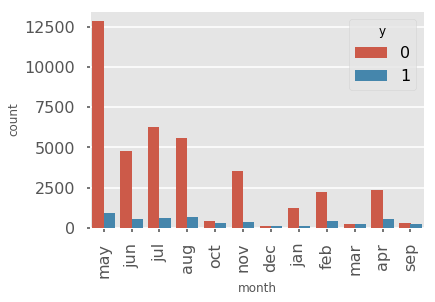

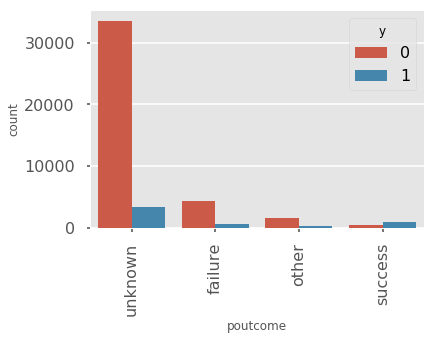

In [12]:
for index,column in enumerate(raw_df.select_dtypes(include='object')):
    sns.countplot(feat[column],hue=raw_df['y'],data=raw_df)
    plt.xticks(rotation=90)
    plt.show()

In [13]:
raw_df[['job', 'y']].groupby("job").mean().reset_index()

,job,y
0,admin,0.122027
1,blue,0.072750
2,entrepreneur,0.082717
3,housemaid,0.087903
4,management,0.137556
5,retired,0.227915
6,self,0.118429
7,services,0.088830
8,student,0.286780
9,technician,0.110570


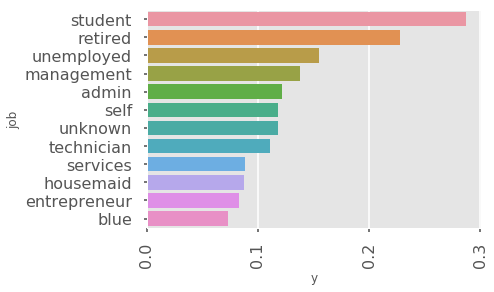

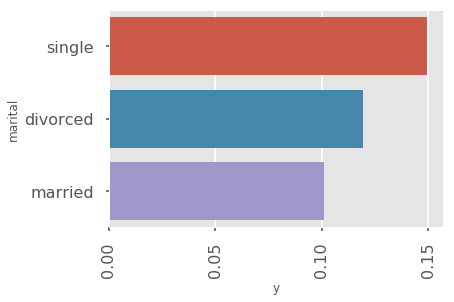

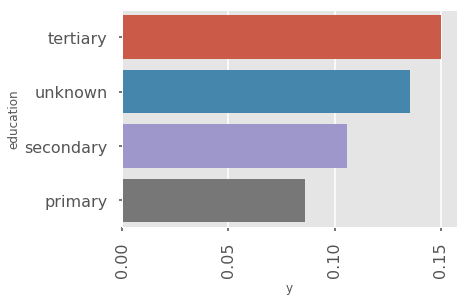

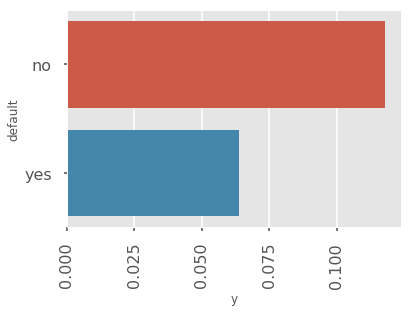

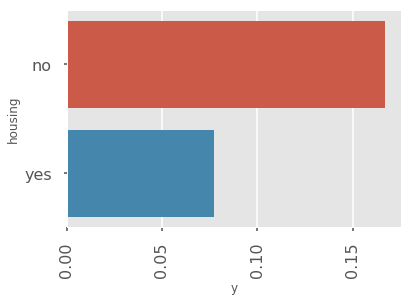

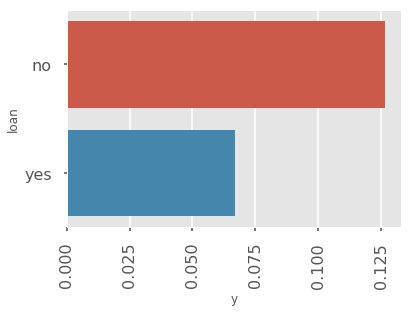

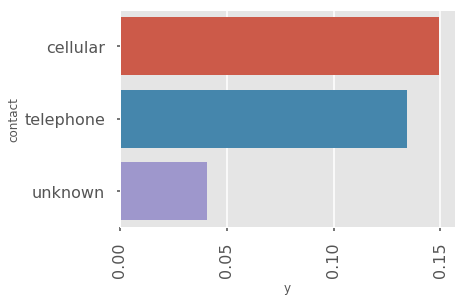

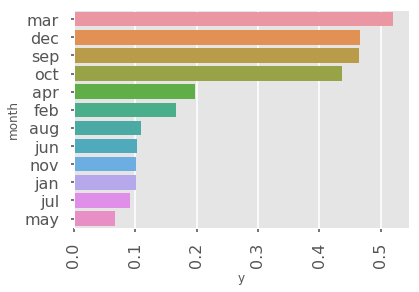

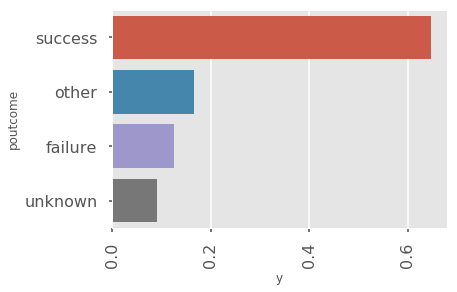

In [14]:
for index,column in enumerate(raw_df.select_dtypes(include='object')):
    index=raw_df[[column, 'y']].groupby(column).mean().reset_index().sort_values('y', ascending=False)
    sns.barplot(y = column, x = 'y',data = index)
    plt.xticks(rotation=90)
    plt.show()

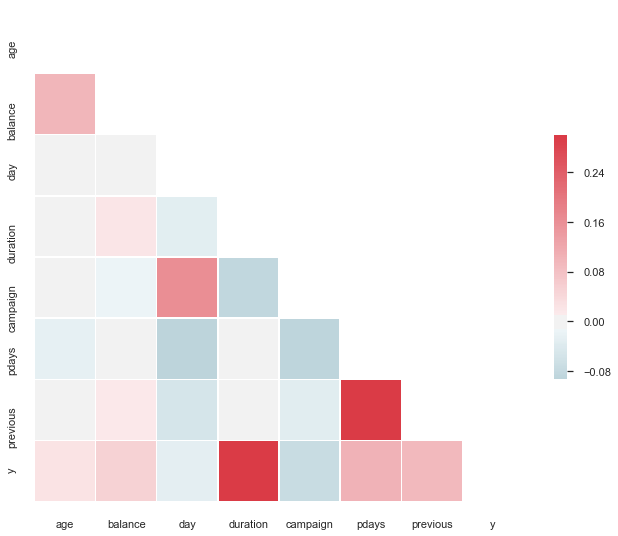

In [15]:
# Compute the correlation matrix
corr = raw_df.corr()

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Model

## Initial Basic Model's

In [16]:
#create variables
X=scaled_feat
y=raw_df['y']

#split data for modeling
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

In [32]:
#create classifiers for a few basic models
clf_dt=tree.DecisionTreeClassifier()
clf_lr=LogisticRegression()
clf_rf=RandomForestClassifier()
clf_svm=svm.SVC()
clf_xgb=xgb.XGBClassifier()

#lists to loop through
classifiers=[clf_xgb,clf_dt,clf_lr,clf_rf,clf_svm]
names=['XGBoost','Decision Tree','Logistic Regression',
       'Random Forest','Support Vector Machine']

#loop to print Accuracy and F1 Score
for index , clf in enumerate(classifiers):
    clf.fit(X_train,y_train)
    print('{} basic model accuracy score {:.4}%'.format(names[index],clf.score(X_test,y_test)*100))
    print('{} basic model F1 score {:.4}'.format(names[index],f1_score(y_test,clf.predict(X_test))))
    print('\n')
    

XGBoost basic model accuracy score 89.33%
XGBoost basic model F1 score 0.2696


Decision Tree basic model accuracy score 83.24%
Decision Tree basic model F1 score 0.3081


Logistic Regression basic model accuracy score 89.32%
Logistic Regression basic model F1 score 0.2657


Random Forest basic model accuracy score 88.96%
Random Forest basic model F1 score 0.2921


Support Vector Machine basic model accuracy score 89.41%
Support Vector Machine basic model F1 score 0.2968




Based on these initial models, I am interested in finding out more information on the XGBoost, which is a very powerful model, with high accuracy and much quicker than the SVM model. I am also interested in the Random Forest model as it has a high F1 score as well as accuracy score.

In [35]:
#create predicitons basesd on training and testing data
rf_training_preds = clf_rf.predict(X_train)
rf_testing_preds = clf_rf.predict(X_test)

xgb_training_preds = clf_xgb.predict(X_train)
xgb_testing_preds = clf_xgb.predict(X_test)

In [36]:
#define function to show accuracy and f1 scores and confusion matrix
def test_model_performance(y,preds,model):
    print('{} Performance'.format(model))
    print('--------------')
    
    #print accuracy score as percentage
    print("Accuracy: {:.4}%".format(
        accuracy_score(y,preds) * 100))
    
    #print AUC
    fpr, tpr, thresholds = roc_curve(y, preds)
    roc_auc = auc(fpr, tpr)
    print("AUC is: {:.2}".format(roc_auc))
    
    #f1_score
    print("F1: {:.4}".format(
        f1_score(y,preds)))
    
    #create and plot confusion matrix
    cnf_matrix = confusion_matrix(y,preds)
    plot_confusion_matrix(cnf_matrix)

    

#define function to plot confusion matrix
def plot_confusion_matrix(cnf_matrix):
    plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) #Create the basic matrix.
    sns.set_style("dark")
    
    #Add title and Axis Labels
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    #Add appropriate Axis Scales
    class_names = set(y) #Get class labels to add to matrix
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    #Add Labels to Each Cell
    thresh = cnf_matrix.max() / 2. #Used for text coloring below
    
    #Here we iterate through the confusion matrix and append labels to our visualization.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    #Add a Side Bar Legend Showing Colors
    plt.colorbar()
    plt.show()

Random Forest Training Performance
--------------
Accuracy: 98.57%
AUC is: 0.94
F1: 0.9357


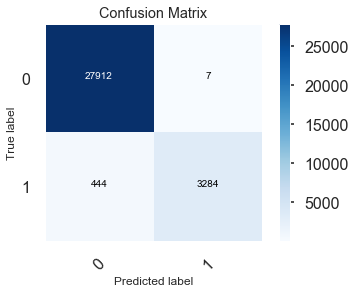

Random Forest Testing Performance
--------------
Accuracy: 88.96%
AUC is: 0.59
F1: 0.2921


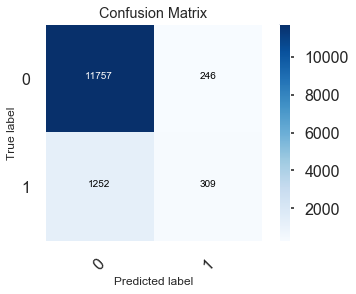

XGboost Training Performance
--------------
Accuracy: 89.74%
AUC is: 0.6
F1: 0.3242


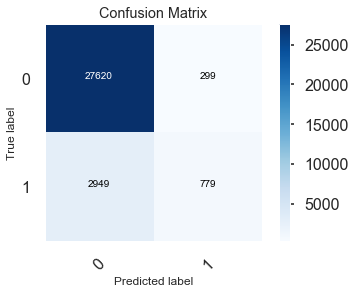

XGboost Testing Performance
--------------
Accuracy: 89.33%
AUC is: 0.58
F1: 0.2696


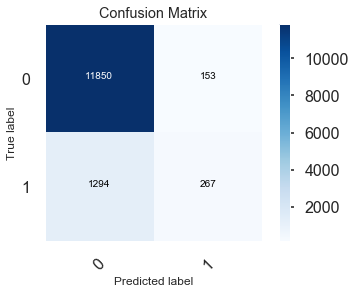

In [37]:
#print model performance for both models training and testing predictions
test_model_performance(y_train,rf_training_preds,'Random Forest Training')
test_model_performance(y_test,rf_testing_preds,'Random Forest Testing')

test_model_performance(y_train,xgb_training_preds,'XGboost Training')
test_model_performance(y_test,xgb_testing_preds,'XGboost Testing')

Based on the perfomance of this basic model, we have some tuning to do. Some of the issues that I see with this model is that we have a very imbalanced dataset in terms of classifiers. This can be seen by simply printing the value_counts of the target data but can be confirmed through this first model. Because of this, we want to focus on the F1 score of our dataset as the F1 score is a measurement of the balance between precision and recall. 

We have a high accuracy score but we have a low F1 score, meaning we need to focus on balancing and improving our model. 

My plan to improve my model is to:

1. Balance my training data using SMOTE
    - Retrain our classifier
2. Determine the final algorith
    - Use GridSearchCV to tune the parameters
3. Re-evaluate and repeat step 2 as necessary

### 1. Balance data using SMOTE

In [12]:
print(y_train.value_counts()) #Previous original class distribution
X_train_resampled, y_train_resampled = SMOTE().fit_sample(X_train, y_train) 
print(pd.Series(y_train_resampled).value_counts())#Preview synthetic sample class distribution

#change to DataFrame from array
X_train_resampled=pd.DataFrame(X_train_resampled,columns=X_train.columns)

0    27915
1     3732
Name: y, dtype: int64
1    27915
0    27915
dtype: int64


Random Forest Training Performance
--------------
Accuracy: 99.6%
AUC is: 1.0
F1: 0.996


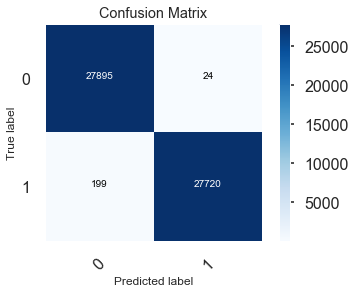

Random Forest Testing Performance
--------------
Accuracy: 87.59%
AUC is: 0.62
F1: 0.3479


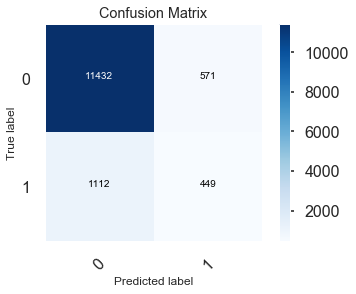

XGboost Training Performance
--------------
Accuracy: 88.99%
AUC is: 0.89
F1: 0.8834


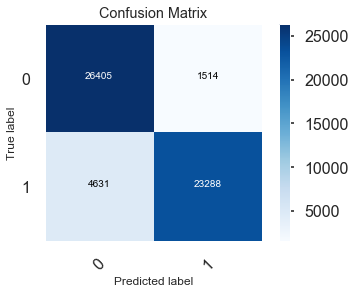

XGboost Testing Performance
--------------
Accuracy: 87.86%
AUC is: 0.65
F1: 0.4035


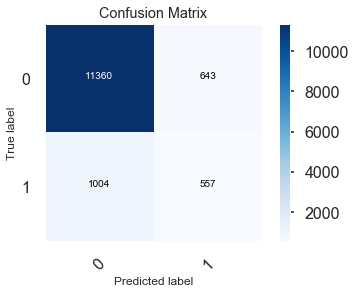

In [39]:
#use XGboost for modeling
clf_xgb = xgb.XGBClassifier()
clf_xgb.fit(X_train_resampled, y_train_resampled)

#use Random Forest for modeling
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train_resampled, y_train_resampled)


#create predicitons based on training and testing data
rf_training_preds = clf_rf.predict(X_train_resampled)
rf_testing_preds = clf_rf.predict(X_test)

xgb_training_preds = clf_xgb.predict(X_train_resampled)
xgb_testing_preds = clf_xgb.predict(X_test)

#quick performance assessment
test_model_performance(y_train_resampled,rf_training_preds,'Random Forest Training')
test_model_performance(y_test,rf_testing_preds,'Random Forest Testing')

test_model_performance(y_train_resampled,xgb_training_preds,'XGboost Training')
test_model_performance(y_test,xgb_testing_preds,'XGboost Testing')

Resampling has greatly improved our training F1 score for both the Random Forest as well as the XGBoost models. Based on this data, it seems that the XGBoost model performs slightly better on the testing data and therefore I will use this algorith for tuning purposes. 

## 2 .Tuning our Model

I ended up running through this process multiple time. The first time I tuned my model I used accuracy as a scoring measure but ultimatly decided that I wanted to use roc_auc because of the imbalanced nature of the dataset. With this imbalance, tuning for accuracy would only potentially increase the bias of the imbalanced dataset. 

In [74]:
#create paramater grid to loop through
param_grid = {
    'max_depth': [3,4,5,6],
    'n_estimators': [50, 100, 350, 500, 1000],
}

#use Gridsearch to loop through
grid_clf = GridSearchCV(clf_xgb, param_grid, scoring='roc_auc', cv=5, n_jobs=1)
grid_clf.fit(X_train_resampled, y_train_resampled)

#find the best parameters
best_parameters = grid_clf.best_params_

#print the best parameters
print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

Grid Search found the following optimal parameters: 
max_depth: 6
n_estimators: 500


XGBoost resampled Performance
--------------
Accuracy: 95.97%
AUC is: 0.96
F1: 0.9584


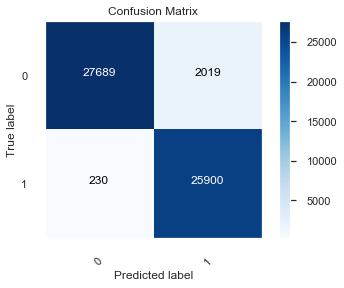

XGBoost test resampled Performance
--------------
Accuracy: 89.32%
AUC is: 0.74
F1: 0.3807


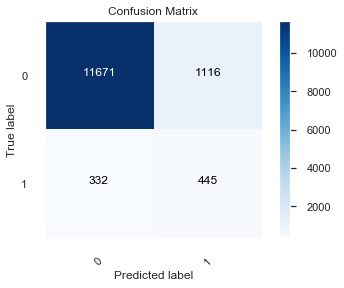

In [75]:
#Use the model to predict
cv_training_preds = grid_clf.predict(X_train_resampled)
cv_testing_preds=grid_clf.predict(X_test)

#quick performance preview
test_model_performance(cv_training_preds,y_train_resampled,"XGBoost resampled")
test_model_performance(cv_testing_preds,y_test,"XGBoost test resampled")

This first round of tuning greatly increased our training accuracy, AUC and F1 score however this is not the caise with our testing predictions. With our testing data, our AUC and accuracy increased but F1 score decreased. Let's try tuning some other variables and see how this improves. 

In [76]:
#adding some additional tuning parameters while keeping those we already found constant.
param_grid = {
    'gamma':[i/10.0 for i in range(0,3)],
    'max_depth': [6],
    'subsample':[i/10.0 for i in range(6,9)],
    'n_estimators': [500],
}
#Using GridsearchCV to loop
grid_clf = GridSearchCV(clf_xgb, param_grid, scoring='roc_auc', cv=5, n_jobs=1)
grid_clf.fit(X_train_resampled, y_train_resampled)

#creating list of best parameters
best_parameters = grid_clf.best_params_

#printing parameters
print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

Grid Search found the following optimal parameters: 
gamma: 0.1
max_depth: 6
n_estimators: 500
subsample: 0.6


XGBoost resampled Performance
--------------
Accuracy: 96.17%
AUC is: 0.96
F1: 0.9605


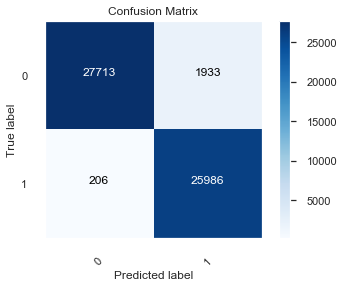

XGBoost test resampled Performance
--------------
Accuracy: 89.28%
AUC is: 0.74
F1: 0.3765


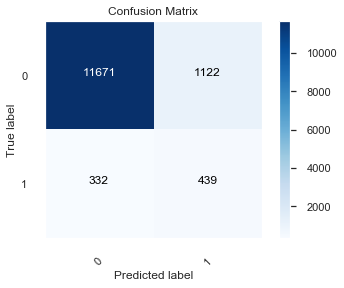

In [77]:
#create predicitons based on training and testing data
cv_training_preds = grid_clf.predict(X_train_resampled)
cv_testing_preds=grid_clf.predict(X_test)

#quick performance analysis
test_model_performance(cv_training_preds,y_train_resampled,"XGBoost resampled")
test_model_performance(cv_testing_preds,y_test,"XGBoost test resampled")

We had another improvement for the testing data but another slight decrease in Accuracy, AUC and F1 score for the testing data. This is starting to indicate that I might be overfitting my model as I continue to tune the parameters. That being said, I want to try to tune the model a little more and see how that effects it. 

In [78]:
#adding a few more parameters
param_grid = {
    'gamma':[0.1],
    'learning_rate': [0.001,0.01,0.1,0.2],
    'max_depth': [6],
    'min_child_weight': [4,6,8,10],
    'subsample':[0.6],
    'n_estimators': [500],
}

#loop through the fitting process
grid_clf = GridSearchCV(clf_xgb, param_grid, scoring='roc_auc', cv=5, n_jobs=1)
grid_clf.fit(X_train_resampled, y_train_resampled)

#create list of best parameters
best_parameters = grid_clf.best_params_

#print optimal parameters
print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

Grid Search found the following optimal parameters: 
gamma: 0.1
learning_rate: 0.2
max_depth: 6
min_child_weight: 6
n_estimators: 500
subsample: 0.6


XGBoost resampled Performance
--------------
Accuracy: 96.55%
AUC is: 0.97
F1: 0.9646


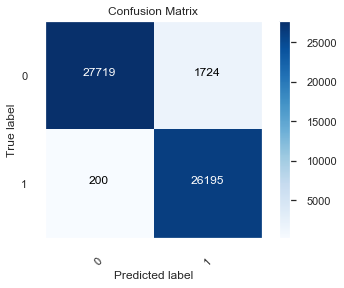

XGBoost test resampled Performance
--------------
Accuracy: 88.86%
AUC is: 0.72
F1: 0.3675


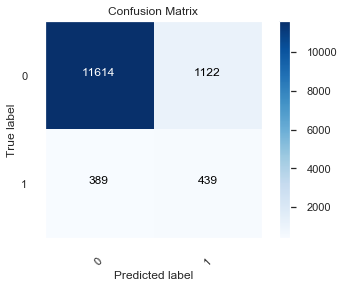

In [79]:
#create predicitons based on training and testing data
cv_training_preds = grid_clf.predict(X_train_resampled)
cv_testing_preds=grid_clf.predict(X_test)

#quick performance analysis
test_model_performance(cv_training_preds,y_train_resampled,"XGBoost resampled")
test_model_performance(cv_testing_preds,y_test,"XGBoost test resampled")

In [13]:
#create and fit my final model
final_model_1=xgb.XGBClassifier(gamma=0.1, 
                              learning_rate=0.2, 
                              max_depth=6, 
                              min_child_weight=6, 
                              n_estimators=500, 
                              subsample=0.6)

final_model_1.fit(X_train_resampled,y_train_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.1, learning_rate=0.2, max_delta_step=0,
       max_depth=6, min_child_weight=6, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.6)

Train AUC: 0.9655431784806046
Test AUC: 0.6244107081280076


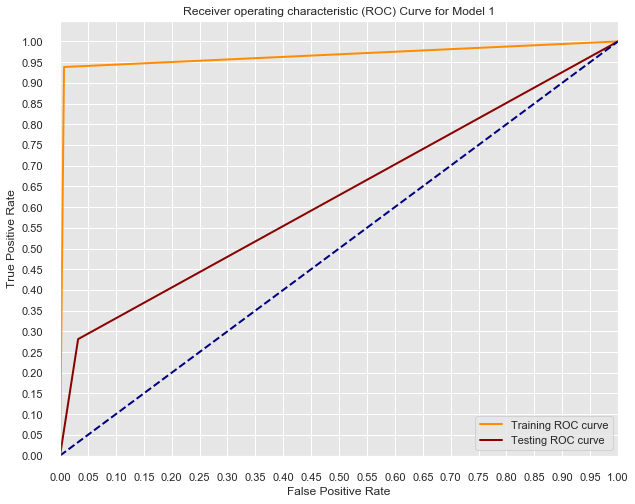

In [125]:
#create predictons

training_preds=final_model_1.predict(X_train_resampled)
testing_preds=final_model_1.predict(X_test)

#create false_positive_rate, true_positive_rates and thresholds for predictions
train_fpr, train_tpr, train_thresholds = roc_curve(y_train_resampled, training_preds)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, testing_preds)

#set style to dark
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

plt.figure(figsize=(10,8))
lw = 2

#plot training ROC
plt.plot(train_fpr, train_tpr, color='darkorange',
         lw=lw, label='Training ROC curve')

#plot testing roc
plt.plot(test_fpr, test_tpr, color='darkred',
         lw=lw, label='Testing ROC curve')

#plot line of random choice
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

#set graph parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Model 1')
plt.legend(loc="lower right")

#print AUC for reference
print('Train AUC: {}'.format(auc(train_fpr, train_tpr)))
print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))
plt.show()

As you can see by the ROC Curve, our model is strong when predicting our training data however is significantly weaker when predicting our testing data and only slightly better than chance. In other words, if we tune our training model to predict 95% accuracy in predicting true positives we will have a 12% chance of a false positive. When using new information, our model is much less impressive. If we tune our model to 50% true positive rate, we will have a 33% false positive rate. At this point, we have a good model for modeling purposes but it is a poor predictor.


## Model 2

I believe that this is due to overfitting problem I mentioned earlier and one way to potentially fix that issue is to use PCA(Principal Component Analysis). This will allow us to compress or reduce the dimensionality of our dataset which will speed up our process as well as potentially help our overfitting issue.

For this model, I will use PCA to reduce the dimensionality but retain 80% of the variance in the dataset. This will give me the number of components I will need. 

In [106]:
pca = PCA(.80) # Retain 80% of the variance
pca_feat = pca.fit_transform(scaled_feat)
pca.n_components_ # Check number of components for required variance

27

In [122]:
pipe_xgb = Pipeline([('pca', PCA(n_components=27)),
        ('clf', xgb.XGBClassifier(gamma=0.1, 
                              learning_rate=0.2, 
                              max_depth=6, 
                              min_child_weight=6, 
                              n_estimators=500, 
                              subsample=0.6))])

pipe_xgb.fit(X_train_resampled,y_train_resampled)

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=27, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.1, learning_rate=0.2, max_delta_step=0,
       max_de...      reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.6))])

Train AUC: 0.9502847523192092
Test AUC: 0.6612249083789271


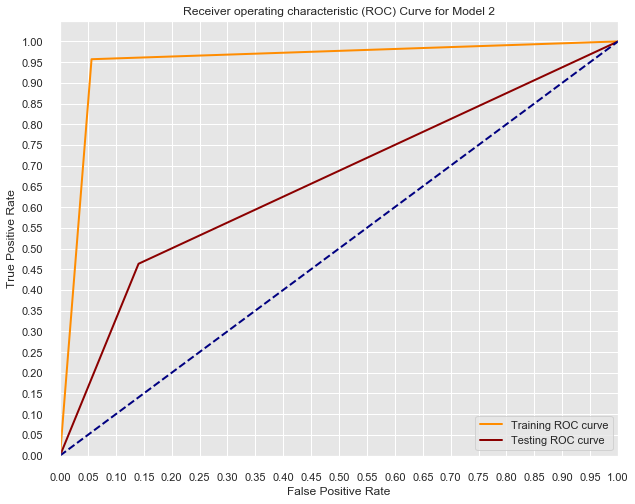

In [123]:
#create predictons
training_preds=pipe_xgb.predict(X_train_resampled)
testing_preds=pipe_xgb.predict(X_test)

#create false_positive_rate, true_positive_rates and thresholds for predictions
train_fpr, train_tpr, train_thresholds = roc_curve(y_train_resampled, training_preds)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, testing_preds)

#set style to dark
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

plt.figure(figsize=(10,8))
lw = 2

#plot training ROC
plt.plot(train_fpr, train_tpr, color='darkorange',
         lw=lw, label='Training ROC curve')

#plot testing ROC
plt.plot(test_fpr, test_tpr, color='darkred',
         lw=lw, label='Testing ROC curve')

#plot random choice line
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

#set graph parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Model 2')
plt.legend(loc="lower right")

#print AUC for reference
print('Train AUC: {}'.format(auc(train_fpr, train_tpr)))
print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))

plt.show()

As you can see from the graph above, the AUC decrease a little for the training data but increase for the testing data. Using the same points we used before. For a 95% true positive rate in the training data we actually see a decrease to only a 6% false positive rate. When it comes to testing the data, for a 50% true positive rate we see a decrease to 21% false positive rate. 

Because we made progress using this method, I decided to retune my parameters to see if I can improved the ROC_AUC for my testing data. 

In [115]:
#create pipeline
pipe_xgb = Pipeline([('pca', PCA(n_components=27)),
        ('clf', xgb.XGBClassifier())])

# Set grid search params
param_grid_xgb = [ 
  {'clf__gamma':[i/10.0 for i in range(0,2)],
   'clf__learning_rate': [0.001,0.1], 
   'clf__subsample':[i/10.0 for i in range(6,10)],  
   'clf__min_child_weight': [6,8,10],  
   'clf__max_depth': [4,5,6],
   'clf__n_estimators': [100, 350, 500,],
  }
]

gs_xgb = GridSearchCV(estimator=pipe_xgb,
            param_grid=param_grid_xgb,
            scoring='roc_auc',
            cv=3, verbose=2, return_train_score = True)

# Fit using gridsearch
gs_xgb.fit(X_train_resampled, y_train_resampled)

# Best accuracy
print('Best accuracy: %.3f' % gs_xgb.best_score_)

# Best parameters
print('\nBest params:\n', gs_xgb.best_params_)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
[CV] clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=6, clf__n_estimators=100, clf__subsample=0.6 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=6, clf__n_estimators=100, clf__subsample=0.6, total=  14.0s
[CV] clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=6, clf__n_estimators=100, clf__subsample=0.6 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.2s remaining:    0.0s


[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=6, clf__n_estimators=100, clf__subsample=0.6, total=  13.5s
[CV] clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=6, clf__n_estimators=100, clf__subsample=0.6 
[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=6, clf__n_estimators=100, clf__subsample=0.6, total=  13.5s
[CV] clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=6, clf__n_estimators=100, clf__subsample=0.7 
[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=6, clf__n_estimators=100, clf__subsample=0.7, total=  13.8s
[CV] clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=6, clf__n_estimators=100, clf__subsample=0.7 
[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=6, clf__n_estimators=100, clf__subsample=0.7, total=  14.4s
[CV] clf_

[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=6, clf__n_estimators=500, clf__subsample=0.8, total= 1.2min
[CV] clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=6, clf__n_estimators=500, clf__subsample=0.8 
[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=6, clf__n_estimators=500, clf__subsample=0.8, total= 1.2min
[CV] clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=6, clf__n_estimators=500, clf__subsample=0.9 
[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=6, clf__n_estimators=500, clf__subsample=0.9, total= 1.5min
[CV] clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=6, clf__n_estimators=500, clf__subsample=0.9 
[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=6, clf__n_estimators=500, clf__subsample=0.9, total= 1.3min
[CV] clf_

[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=8, clf__n_estimators=500, clf__subsample=0.6, total= 1.1min
[CV] clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=8, clf__n_estimators=500, clf__subsample=0.6 
[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=8, clf__n_estimators=500, clf__subsample=0.6, total= 1.2min
[CV] clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=8, clf__n_estimators=500, clf__subsample=0.7 
[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=8, clf__n_estimators=500, clf__subsample=0.7, total= 1.3min
[CV] clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=8, clf__n_estimators=500, clf__subsample=0.7 
[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=8, clf__n_estimators=500, clf__subsample=0.7, total= 1.2min
[CV] clf_

[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=10, clf__n_estimators=350, clf__subsample=0.8, total= 1.1min
[CV] clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=10, clf__n_estimators=350, clf__subsample=0.8 
[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=10, clf__n_estimators=350, clf__subsample=0.8, total=  51.8s
[CV] clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=10, clf__n_estimators=350, clf__subsample=0.9 
[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=10, clf__n_estimators=350, clf__subsample=0.9, total=  55.3s
[CV] clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=10, clf__n_estimators=350, clf__subsample=0.9 
[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=10, clf__n_estimators=350, clf__subsample=0.9, total=  57.6s
[C

[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=6, clf__n_estimators=350, clf__subsample=0.6, total=  58.5s
[CV] clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=6, clf__n_estimators=350, clf__subsample=0.6 
[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=6, clf__n_estimators=350, clf__subsample=0.6, total= 1.1min
[CV] clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=6, clf__n_estimators=350, clf__subsample=0.7 
[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=6, clf__n_estimators=350, clf__subsample=0.7, total= 1.1min
[CV] clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=6, clf__n_estimators=350, clf__subsample=0.7 
[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=6, clf__n_estimators=350, clf__subsample=0.7, total= 1.1min
[CV] clf_

[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=8, clf__n_estimators=100, clf__subsample=0.8, total=  18.2s
[CV] clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=8, clf__n_estimators=100, clf__subsample=0.8 
[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=8, clf__n_estimators=100, clf__subsample=0.8, total=  18.0s
[CV] clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=8, clf__n_estimators=100, clf__subsample=0.9 
[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=8, clf__n_estimators=100, clf__subsample=0.9, total=  19.2s
[CV] clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=8, clf__n_estimators=100, clf__subsample=0.9 
[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=8, clf__n_estimators=100, clf__subsample=0.9, total=  19.5s
[CV] clf_

[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=100, clf__subsample=0.6, total=  16.6s
[CV] clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=100, clf__subsample=0.6 
[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=100, clf__subsample=0.6, total=  16.3s
[CV] clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=100, clf__subsample=0.7 
[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=100, clf__subsample=0.7, total=  17.4s
[CV] clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=100, clf__subsample=0.7 
[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=100, clf__subsample=0.7, total=  17.2s
[C

[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=500, clf__subsample=0.8, total= 1.7min
[CV] clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=500, clf__subsample=0.8 
[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=500, clf__subsample=0.8, total= 1.8min
[CV] clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=500, clf__subsample=0.8 
[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=500, clf__subsample=0.8, total= 1.9min
[CV] clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=500, clf__subsample=0.9 
[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=500, clf__subsample=0.9, total= 1.8min
[C

[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=6, clf__n_estimators=500, clf__subsample=0.6, total= 1.8min
[CV] clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=6, clf__n_estimators=500, clf__subsample=0.6 
[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=6, clf__n_estimators=500, clf__subsample=0.6, total= 1.8min
[CV] clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=6, clf__n_estimators=500, clf__subsample=0.6 
[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=6, clf__n_estimators=500, clf__subsample=0.6, total= 1.9min
[CV] clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=6, clf__n_estimators=500, clf__subsample=0.7 
[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=6, clf__n_estimators=500, clf__subsample=0.7, total= 2.0min
[CV] clf_

[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=8, clf__n_estimators=350, clf__subsample=0.8, total= 1.3min
[CV] clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=8, clf__n_estimators=350, clf__subsample=0.8 
[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=8, clf__n_estimators=350, clf__subsample=0.8, total= 1.3min
[CV] clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=8, clf__n_estimators=350, clf__subsample=0.8 
[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=8, clf__n_estimators=350, clf__subsample=0.8, total= 1.3min
[CV] clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=8, clf__n_estimators=350, clf__subsample=0.9 
[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=8, clf__n_estimators=350, clf__subsample=0.9, total= 1.4min
[CV] clf_

[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=10, clf__n_estimators=350, clf__subsample=0.6, total= 1.2min
[CV] clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=10, clf__n_estimators=350, clf__subsample=0.6 
[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=10, clf__n_estimators=350, clf__subsample=0.6, total= 1.1min
[CV] clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=10, clf__n_estimators=350, clf__subsample=0.6 
[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=10, clf__n_estimators=350, clf__subsample=0.6, total= 1.0min
[CV] clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=10, clf__n_estimators=350, clf__subsample=0.7 
[CV]  clf__gamma=0.0, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=10, clf__n_estimators=350, clf__subsample=0.7, total= 1.1min
[C

[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=6, clf__n_estimators=100, clf__subsample=0.8, total=  20.2s
[CV] clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=6, clf__n_estimators=100, clf__subsample=0.8 
[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=6, clf__n_estimators=100, clf__subsample=0.8, total=  16.8s
[CV] clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=6, clf__n_estimators=100, clf__subsample=0.8 
[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=6, clf__n_estimators=100, clf__subsample=0.8, total=  19.0s
[CV] clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=6, clf__n_estimators=100, clf__subsample=0.9 
[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=6, clf__n_estimators=100, clf__subsample=0.9, total=  17.2s
[CV] clf__gamma=0.0, cl

[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=8, clf__n_estimators=100, clf__subsample=0.6, total=  13.2s
[CV] clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=8, clf__n_estimators=100, clf__subsample=0.6 
[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=8, clf__n_estimators=100, clf__subsample=0.6, total=  12.7s
[CV] clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=8, clf__n_estimators=100, clf__subsample=0.6 
[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=8, clf__n_estimators=100, clf__subsample=0.6, total=  12.8s
[CV] clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=8, clf__n_estimators=100, clf__subsample=0.7 
[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=8, clf__n_estimators=100, clf__subsample=0.7, total=  13.4s
[CV] clf__gamma=0.0, cl

[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=8, clf__n_estimators=500, clf__subsample=0.8, total= 1.2min
[CV] clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=8, clf__n_estimators=500, clf__subsample=0.8 
[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=8, clf__n_estimators=500, clf__subsample=0.8, total= 1.2min
[CV] clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=8, clf__n_estimators=500, clf__subsample=0.8 
[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=8, clf__n_estimators=500, clf__subsample=0.8, total= 1.1min
[CV] clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=8, clf__n_estimators=500, clf__subsample=0.9 
[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=8, clf__n_estimators=500, clf__subsample=0.9, total= 1.2min
[CV] clf__gamma=0.0, cl

[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=10, clf__n_estimators=500, clf__subsample=0.6, total= 1.0min
[CV] clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=10, clf__n_estimators=500, clf__subsample=0.6 
[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=10, clf__n_estimators=500, clf__subsample=0.6, total= 1.0min
[CV] clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=10, clf__n_estimators=500, clf__subsample=0.6 
[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=10, clf__n_estimators=500, clf__subsample=0.6, total=  58.3s
[CV] clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=10, clf__n_estimators=500, clf__subsample=0.7 
[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=10, clf__n_estimators=500, clf__subsample=0.7, total= 1.0min
[CV] clf__gamma=

[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=6, clf__n_estimators=350, clf__subsample=0.8, total=  57.5s
[CV] clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=6, clf__n_estimators=350, clf__subsample=0.8 
[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=6, clf__n_estimators=350, clf__subsample=0.8, total=  56.5s
[CV] clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=6, clf__n_estimators=350, clf__subsample=0.8 
[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=6, clf__n_estimators=350, clf__subsample=0.8, total=  57.8s
[CV] clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=6, clf__n_estimators=350, clf__subsample=0.9 
[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=6, clf__n_estimators=350, clf__subsample=0.9, total= 1.0min
[CV] clf__gamma=0.0, cl

[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=8, clf__n_estimators=350, clf__subsample=0.6, total=  51.5s
[CV] clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=8, clf__n_estimators=350, clf__subsample=0.6 
[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=8, clf__n_estimators=350, clf__subsample=0.6, total=  51.3s
[CV] clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=8, clf__n_estimators=350, clf__subsample=0.6 
[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=8, clf__n_estimators=350, clf__subsample=0.6, total=  51.6s
[CV] clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=8, clf__n_estimators=350, clf__subsample=0.7 
[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=8, clf__n_estimators=350, clf__subsample=0.7, total=  57.2s
[CV] clf__gamma=0.0, cl

[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=100, clf__subsample=0.8, total=  15.7s
[CV] clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=100, clf__subsample=0.8 
[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=100, clf__subsample=0.8, total=  16.0s
[CV] clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=100, clf__subsample=0.8 
[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=100, clf__subsample=0.8, total=  15.5s
[CV] clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=100, clf__subsample=0.9 
[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=100, clf__subsample=0.9, total=  16.3s
[CV] clf__gamma=

[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=6, clf__n_estimators=100, clf__subsample=0.6, total=  16.9s
[CV] clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=6, clf__n_estimators=100, clf__subsample=0.6 
[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=6, clf__n_estimators=100, clf__subsample=0.6, total=  16.8s
[CV] clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=6, clf__n_estimators=100, clf__subsample=0.6 
[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=6, clf__n_estimators=100, clf__subsample=0.6, total=  16.8s
[CV] clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=6, clf__n_estimators=100, clf__subsample=0.7 
[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=6, clf__n_estimators=100, clf__subsample=0.7, total=  17.7s
[CV] clf__gamma=0.0, cl

[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=6, clf__n_estimators=500, clf__subsample=0.8, total= 1.5min
[CV] clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=6, clf__n_estimators=500, clf__subsample=0.8 
[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=6, clf__n_estimators=500, clf__subsample=0.8, total= 1.5min
[CV] clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=6, clf__n_estimators=500, clf__subsample=0.8 
[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=6, clf__n_estimators=500, clf__subsample=0.8, total= 1.5min
[CV] clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=6, clf__n_estimators=500, clf__subsample=0.9 
[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=6, clf__n_estimators=500, clf__subsample=0.9, total= 1.6min
[CV] clf__gamma=0.0, cl

[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=8, clf__n_estimators=500, clf__subsample=0.6, total= 1.4min
[CV] clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=8, clf__n_estimators=500, clf__subsample=0.6 
[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=8, clf__n_estimators=500, clf__subsample=0.6, total= 1.3min
[CV] clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=8, clf__n_estimators=500, clf__subsample=0.6 
[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=8, clf__n_estimators=500, clf__subsample=0.6, total= 1.3min
[CV] clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=8, clf__n_estimators=500, clf__subsample=0.7 
[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=8, clf__n_estimators=500, clf__subsample=0.7, total= 1.4min
[CV] clf__gamma=0.0, cl

[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=10, clf__n_estimators=350, clf__subsample=0.8, total= 1.0min
[CV] clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=10, clf__n_estimators=350, clf__subsample=0.8 
[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=10, clf__n_estimators=350, clf__subsample=0.8, total= 1.0min
[CV] clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=10, clf__n_estimators=350, clf__subsample=0.8 
[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=10, clf__n_estimators=350, clf__subsample=0.8, total= 1.0min
[CV] clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=10, clf__n_estimators=350, clf__subsample=0.9 
[CV]  clf__gamma=0.0, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=10, clf__n_estimators=350, clf__subsample=0.9, total= 1.1min
[CV] clf__gamma=

[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=6, clf__n_estimators=350, clf__subsample=0.6, total=  40.2s
[CV] clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=6, clf__n_estimators=350, clf__subsample=0.6 
[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=6, clf__n_estimators=350, clf__subsample=0.6, total=  39.6s
[CV] clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=6, clf__n_estimators=350, clf__subsample=0.6 
[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=6, clf__n_estimators=350, clf__subsample=0.6, total=  39.7s
[CV] clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=6, clf__n_estimators=350, clf__subsample=0.7 
[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=6, clf__n_estimators=350, clf__subsample=0.7, total=  42.4s
[CV] clf_

[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=8, clf__n_estimators=100, clf__subsample=0.8, total=  13.0s
[CV] clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=8, clf__n_estimators=100, clf__subsample=0.8 
[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=8, clf__n_estimators=100, clf__subsample=0.8, total=  13.0s
[CV] clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=8, clf__n_estimators=100, clf__subsample=0.8 
[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=8, clf__n_estimators=100, clf__subsample=0.8, total=  13.0s
[CV] clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=8, clf__n_estimators=100, clf__subsample=0.9 
[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=8, clf__n_estimators=100, clf__subsample=0.9, total=  13.5s
[CV] clf_

[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=10, clf__n_estimators=100, clf__subsample=0.6, total=  11.9s
[CV] clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=10, clf__n_estimators=100, clf__subsample=0.6 
[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=10, clf__n_estimators=100, clf__subsample=0.6, total=  11.7s
[CV] clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=10, clf__n_estimators=100, clf__subsample=0.6 
[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=10, clf__n_estimators=100, clf__subsample=0.6, total=  11.8s
[CV] clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=10, clf__n_estimators=100, clf__subsample=0.7 
[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=10, clf__n_estimators=100, clf__subsample=0.7, total=  12.2s
[C

[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=10, clf__n_estimators=500, clf__subsample=0.7, total=  59.5s
[CV] clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=10, clf__n_estimators=500, clf__subsample=0.8 
[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=10, clf__n_estimators=500, clf__subsample=0.8, total= 1.1min
[CV] clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=10, clf__n_estimators=500, clf__subsample=0.8 
[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=10, clf__n_estimators=500, clf__subsample=0.8, total= 1.0min
[CV] clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=10, clf__n_estimators=500, clf__subsample=0.8 
[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=4, clf__min_child_weight=10, clf__n_estimators=500, clf__subsample=0.8, total= 1.0min
[C

[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=6, clf__n_estimators=350, clf__subsample=0.9, total=  59.1s
[CV] clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=6, clf__n_estimators=500, clf__subsample=0.6 
[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=6, clf__n_estimators=500, clf__subsample=0.6, total= 1.2min
[CV] clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=6, clf__n_estimators=500, clf__subsample=0.6 
[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=6, clf__n_estimators=500, clf__subsample=0.6, total= 1.2min
[CV] clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=6, clf__n_estimators=500, clf__subsample=0.6 
[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=6, clf__n_estimators=500, clf__subsample=0.6, total= 1.2min
[CV] clf_

[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=8, clf__n_estimators=350, clf__subsample=0.7, total=  53.1s
[CV] clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=8, clf__n_estimators=350, clf__subsample=0.8 
[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=8, clf__n_estimators=350, clf__subsample=0.8, total=  56.3s
[CV] clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=8, clf__n_estimators=350, clf__subsample=0.8 
[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=8, clf__n_estimators=350, clf__subsample=0.8, total=  56.2s
[CV] clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=8, clf__n_estimators=350, clf__subsample=0.8 
[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=8, clf__n_estimators=350, clf__subsample=0.8, total=  55.6s
[CV] clf_

[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=100, clf__subsample=0.9, total=  17.0s
[CV] clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=350, clf__subsample=0.6 
[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=350, clf__subsample=0.6, total=  50.9s
[CV] clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=350, clf__subsample=0.6 
[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=350, clf__subsample=0.6, total=  50.1s
[CV] clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=350, clf__subsample=0.6 
[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=350, clf__subsample=0.6, total=  50.2s
[C

[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=6, clf__n_estimators=100, clf__subsample=0.7, total=  19.0s
[CV] clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=6, clf__n_estimators=100, clf__subsample=0.7 
[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=6, clf__n_estimators=100, clf__subsample=0.7, total=  18.8s
[CV] clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=6, clf__n_estimators=100, clf__subsample=0.8 
[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=6, clf__n_estimators=100, clf__subsample=0.8, total=  20.1s
[CV] clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=6, clf__n_estimators=100, clf__subsample=0.8 
[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=6, clf__n_estimators=100, clf__subsample=0.8, total=  19.7s
[CV] clf_

[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=6, clf__n_estimators=500, clf__subsample=0.9, total= 1.7min
[CV] clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=6, clf__n_estimators=500, clf__subsample=0.9 
[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=6, clf__n_estimators=500, clf__subsample=0.9, total= 1.7min
[CV] clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=8, clf__n_estimators=100, clf__subsample=0.6 
[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=8, clf__n_estimators=100, clf__subsample=0.6, total=  17.9s
[CV] clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=8, clf__n_estimators=100, clf__subsample=0.6 
[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=8, clf__n_estimators=100, clf__subsample=0.6, total=  17.9s
[CV] clf_

[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=8, clf__n_estimators=500, clf__subsample=0.7, total= 1.5min
[CV] clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=8, clf__n_estimators=500, clf__subsample=0.7 
[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=8, clf__n_estimators=500, clf__subsample=0.7, total= 1.5min
[CV] clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=8, clf__n_estimators=500, clf__subsample=0.8 
[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=8, clf__n_estimators=500, clf__subsample=0.8, total= 1.6min
[CV] clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=8, clf__n_estimators=500, clf__subsample=0.8 
[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=8, clf__n_estimators=500, clf__subsample=0.8, total= 1.6min
[CV] clf_

[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=10, clf__n_estimators=350, clf__subsample=0.9, total= 1.2min
[CV] clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=10, clf__n_estimators=350, clf__subsample=0.9 
[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=10, clf__n_estimators=350, clf__subsample=0.9, total= 1.2min
[CV] clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=10, clf__n_estimators=500, clf__subsample=0.6 
[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=10, clf__n_estimators=500, clf__subsample=0.6, total= 1.5min
[CV] clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=10, clf__n_estimators=500, clf__subsample=0.6 
[CV]  clf__gamma=0.1, clf__learning_rate=0.001, clf__max_depth=6, clf__min_child_weight=10, clf__n_estimators=500, clf__subsample=0.6, total= 1.5min
[C

[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=6, clf__n_estimators=350, clf__subsample=0.7, total=  39.3s
[CV] clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=6, clf__n_estimators=350, clf__subsample=0.7 
[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=6, clf__n_estimators=350, clf__subsample=0.7, total=  39.6s
[CV] clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=6, clf__n_estimators=350, clf__subsample=0.8 
[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=6, clf__n_estimators=350, clf__subsample=0.8, total=  42.0s
[CV] clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=6, clf__n_estimators=350, clf__subsample=0.8 
[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=6, clf__n_estimators=350, clf__subsample=0.8, total=  41.8s
[CV] clf__gamma=0.1, cl

[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=8, clf__n_estimators=100, clf__subsample=0.9, total=  13.1s
[CV] clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=8, clf__n_estimators=100, clf__subsample=0.9 
[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=8, clf__n_estimators=100, clf__subsample=0.9, total=  12.9s
[CV] clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=8, clf__n_estimators=350, clf__subsample=0.6 
[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=8, clf__n_estimators=350, clf__subsample=0.6, total=  38.0s
[CV] clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=8, clf__n_estimators=350, clf__subsample=0.6 
[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=8, clf__n_estimators=350, clf__subsample=0.6, total=  37.8s
[CV] clf__gamma=0.1, cl

[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=10, clf__n_estimators=100, clf__subsample=0.7, total=  13.4s
[CV] clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=10, clf__n_estimators=100, clf__subsample=0.7 
[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=10, clf__n_estimators=100, clf__subsample=0.7, total=  13.4s
[CV] clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=10, clf__n_estimators=100, clf__subsample=0.8 
[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=10, clf__n_estimators=100, clf__subsample=0.8, total=  14.3s
[CV] clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=10, clf__n_estimators=100, clf__subsample=0.8 
[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=10, clf__n_estimators=100, clf__subsample=0.8, total=  15.5s
[CV] clf__gamma=

[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=10, clf__n_estimators=500, clf__subsample=0.9, total= 1.1min
[CV] clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=10, clf__n_estimators=500, clf__subsample=0.9 
[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=4, clf__min_child_weight=10, clf__n_estimators=500, clf__subsample=0.9, total= 1.1min
[CV] clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=6, clf__n_estimators=100, clf__subsample=0.6 
[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=6, clf__n_estimators=100, clf__subsample=0.6, total=  15.1s
[CV] clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=6, clf__n_estimators=100, clf__subsample=0.6 
[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=6, clf__n_estimators=100, clf__subsample=0.6, total=  15.4s
[CV] clf__gamma=0.1,

[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=6, clf__n_estimators=500, clf__subsample=0.7, total= 1.3min
[CV] clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=6, clf__n_estimators=500, clf__subsample=0.7 
[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=6, clf__n_estimators=500, clf__subsample=0.7, total= 1.4min
[CV] clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=6, clf__n_estimators=500, clf__subsample=0.8 
[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=6, clf__n_estimators=500, clf__subsample=0.8, total= 1.5min
[CV] clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=6, clf__n_estimators=500, clf__subsample=0.8 
[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=6, clf__n_estimators=500, clf__subsample=0.8, total= 1.4min
[CV] clf__gamma=0.1, cl

[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=8, clf__n_estimators=350, clf__subsample=0.9, total= 1.2min
[CV] clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=8, clf__n_estimators=350, clf__subsample=0.9 
[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=8, clf__n_estimators=350, clf__subsample=0.9, total= 1.2min
[CV] clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=8, clf__n_estimators=500, clf__subsample=0.6 
[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=8, clf__n_estimators=500, clf__subsample=0.6, total= 1.4min
[CV] clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=8, clf__n_estimators=500, clf__subsample=0.6 
[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=8, clf__n_estimators=500, clf__subsample=0.6, total= 1.4min
[CV] clf__gamma=0.1, cl

[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=350, clf__subsample=0.7, total= 1.0min
[CV] clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=350, clf__subsample=0.7 
[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=350, clf__subsample=0.7, total= 1.1min
[CV] clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=350, clf__subsample=0.8 
[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=350, clf__subsample=0.8, total= 1.1min
[CV] clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=350, clf__subsample=0.8 
[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=350, clf__subsample=0.8, total= 1.0min
[CV] clf__gamma=

[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=6, clf__n_estimators=100, clf__subsample=0.9, total=  19.4s
[CV] clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=6, clf__n_estimators=100, clf__subsample=0.9 
[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=6, clf__n_estimators=100, clf__subsample=0.9, total=  19.5s
[CV] clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=6, clf__n_estimators=350, clf__subsample=0.6 
[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=6, clf__n_estimators=350, clf__subsample=0.6, total= 1.0min
[CV] clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=6, clf__n_estimators=350, clf__subsample=0.6 
[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=6, clf__n_estimators=350, clf__subsample=0.6, total=  59.5s
[CV] clf__gamma=0.1, cl

[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=8, clf__n_estimators=100, clf__subsample=0.7, total=  17.6s
[CV] clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=8, clf__n_estimators=100, clf__subsample=0.7 
[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=8, clf__n_estimators=100, clf__subsample=0.7, total=  17.8s
[CV] clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=8, clf__n_estimators=100, clf__subsample=0.8 
[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=8, clf__n_estimators=100, clf__subsample=0.8, total=  18.7s
[CV] clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=8, clf__n_estimators=100, clf__subsample=0.8 
[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=8, clf__n_estimators=100, clf__subsample=0.8, total=  18.5s
[CV] clf__gamma=0.1, cl

[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=8, clf__n_estimators=500, clf__subsample=0.9, total= 1.6min
[CV] clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=8, clf__n_estimators=500, clf__subsample=0.9 
[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=8, clf__n_estimators=500, clf__subsample=0.9, total= 1.6min
[CV] clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=10, clf__n_estimators=100, clf__subsample=0.6 
[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=10, clf__n_estimators=100, clf__subsample=0.6, total=  16.9s
[CV] clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=10, clf__n_estimators=100, clf__subsample=0.6 
[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=10, clf__n_estimators=100, clf__subsample=0.6, total=  16.7s
[CV] clf__gamma=0.1

[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=10, clf__n_estimators=500, clf__subsample=0.7, total= 1.4min
[CV] clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=10, clf__n_estimators=500, clf__subsample=0.7 
[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=10, clf__n_estimators=500, clf__subsample=0.7, total= 1.4min
[CV] clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=10, clf__n_estimators=500, clf__subsample=0.8 
[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=10, clf__n_estimators=500, clf__subsample=0.8, total= 1.5min
[CV] clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=10, clf__n_estimators=500, clf__subsample=0.8 
[CV]  clf__gamma=0.1, clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=10, clf__n_estimators=500, clf__subsample=0.8, total= 1.5min
[CV] clf__gamma=

[Parallel(n_jobs=1)]: Done 1296 out of 1296 | elapsed: 1141.4min finished


Best accuracy: 0.923

Best params:
 {'clf__gamma': 0.1, 'clf__learning_rate': 0.1, 'clf__max_depth': 6, 'clf__min_child_weight': 6, 'clf__n_estimators': 500, 'clf__subsample': 0.8}


In [40]:
final_pipe_xgb = Pipeline([('pca', PCA(n_components=27)),
        ('clf', xgb.XGBClassifier(gamma=0.1, learning_rate=0.1, 
                                  max_depth=6, min_child_weight=6,
                                  n_estimators=500, subsample=0.8))])

final_pipe_xgb.fit(X_train_resampled, y_train_resampled)

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=27, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_delta_step=0,
       max_de...      reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8))])

Train AUC: 0.9167771051971775
Test AUC: 0.6737051590188082


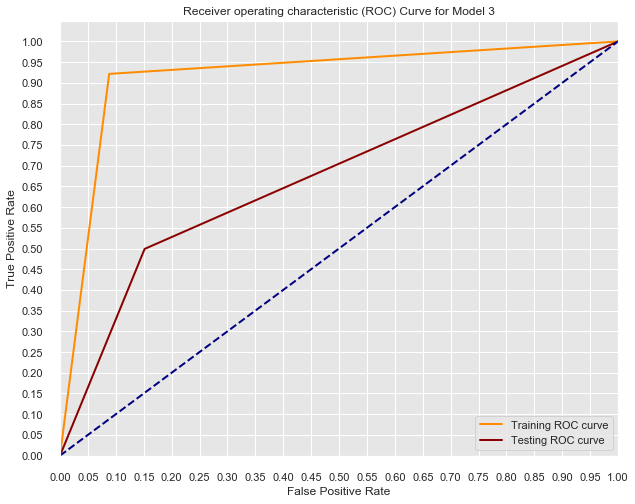

In [121]:
#create predictons
training_preds=final_pipe_xgb.predict(X_train_resampled)
testing_preds=final_pipe_xgb.predict(X_test)

#create false_positive_rate, true_positive_rates and thresholds for predictions
train_fpr, train_tpr, train_thresholds = roc_curve(y_train_resampled, training_preds)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, testing_preds)

#set style to dark
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

plt.figure(figsize=(10,8))
lw = 2

#plot training ROC
plt.plot(train_fpr, train_tpr, color='darkorange',
         lw=lw, label='Training ROC curve')

#plot testing ROC
plt.plot(test_fpr, test_tpr, color='darkred',
         lw=lw, label='Testing ROC curve')

#plot random choice line
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

#set graph parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Model 3')
plt.legend(loc="lower right")

#print AUC for reference
print('Train AUC: {}'.format(auc(train_fpr, train_tpr)))
print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))

plt.show()

In [126]:
feat_2 = raw_df.drop(['y'],axis=1)
binary_feats=['default','housing','loan']
for binary_feat in binary_feats:
    feat_2[binary_feat]=feat_2[binary_feat].map({'no':0,'yes':1})
one_hot_feat_2=pd.get_dummies(feat_2)
scaled_data_2 = scaler.fit_transform(one_hot_feat_2)
scaled_feat_2 = pd.DataFrame(scaled_data_2, columns=one_hot_feat_2.columns)
X_2=scaled_feat_2
y_2=raw_df['y']
#split data for modeling
X_train_2,X_test_2,y_train_2,y_test_2=train_test_split(X_2,y_2,test_size=0.3)
print(y_train_2.value_counts()) #Previous original class distribution
X_train_resampled_2, y_train_resampled_2 = SMOTE().fit_sample(X_train_2, y_train_2) 
print(pd.Series(y_train_resampled_2).value_counts())#Preview synthetic sample class distribution
#change to DataFrame from array
X_train_resampled_2=pd.DataFrame(X_train_resampled_2,columns=X_train_2.columns)

final_pipe_xgb_2 = Pipeline([('pca', PCA(n_components=27)),
        ('clf', xgb.XGBClassifier(gamma=0.1, learning_rate=0.1, 
                                  max_depth=6, min_child_weight=6,
                                  n_estimators=500, subsample=0.8))])

final_pipe_xgb_2.fit(X_train_resampled_2, y_train_resampled_2)



0    27963
1     3684
Name: y, dtype: int64
1    27963
0    27963
dtype: int64


Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=27, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_delta_step=0,
       max_de...      reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8))])

Train AUC: 0.962879519364875
Test AUC: 0.8124004158548979


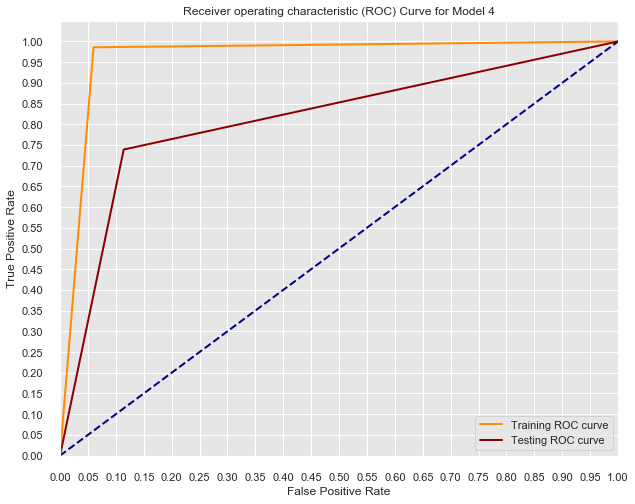

In [127]:
#create predictons
training_preds=final_pipe_xgb_2.predict(X_train_resampled_2)
testing_preds=final_pipe_xgb_2.predict(X_test_2)

#create false_positive_rate, true_positive_rates and thresholds for predictions
train_fpr, train_tpr, train_thresholds = roc_curve(y_train_resampled_2, training_preds)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test_2, testing_preds)

#set style to dark
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

plt.figure(figsize=(10,8))
lw = 2

#plot training ROC
plt.plot(train_fpr, train_tpr, color='darkorange',
         lw=lw, label='Training ROC curve')

#plot testing ROC
plt.plot(test_fpr, test_tpr, color='darkred',
         lw=lw, label='Testing ROC curve')

#plot random choice line
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

#set graph parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Model 4')
plt.legend(loc="lower right")

#print AUC for reference
print('Train AUC: {}'.format(auc(train_fpr, train_tpr)))
print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))

plt.show()

# Interpret

## Model 1

In [37]:
import eli5 as e5

e5.explain_weights(final_model_1)

Weight,Feature
0.1741,poutcome_success
0.1007,housing
0.0639,contact_cellular
0.0624,campaign
0.0587,loan
0.0540,contact_unknown
0.0394,month_mar
0.0295,marital_married
0.0294,month_oct
0.0288,month_apr


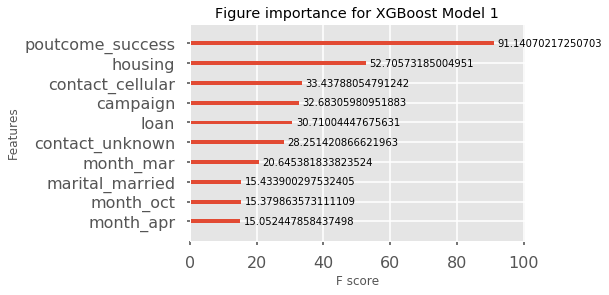

In [54]:

xgb.plot_importance(final_model_1 ,max_num_features=10,
                    title="Figure importance for XGBoost Model 1",
                    importance_type='gain');
